In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import sys
import os
import yaml
import pickle as pickle
import pandas as pd
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
import colorcet as cc
from shapely.geometry.polygon import Polygon
import shapely.ops as ops
from functools import partial
import pyproj

from src.inversion_scripts.utils import plot_field, load_obj, sum_total_emissions, count_obs_in_mask

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
os.environ['ESMFMKFILE'] = '/n/home12/mhe/.conda/envs/imi_env/lib/esmf.mk'

In [3]:
# Open the state vector file
state_vector_filepath = "~/mhe/Global_IMI_2019/NativeStateVector.nc"
state_vector = xr.load_dataset(state_vector_filepath)
state_vector_labels = state_vector["StateVector"]

# Identify the last element of the region of interest
last_ROI_element = int(np.nanmax(state_vector_labels.values))

# Define mask for region of interest
mask = (state_vector_labels <= last_ROI_element)

## January 2019

In [17]:
prior_pth_old = "~/mhe/Global_IMI_2019/preview_run/OutputDir/HEMCO_diagnostics.201901010000.nc"
prior_pth = "~/mhe/Global_IMI_2019/jacobian_runs_jan/Global_IMI_2019_0000/OutputDir/HEMCO_diagnostics.201901010000.nc"
results_pth = "~/mhe/gridded_posterior_20190101.nc"
inversion_result_path = "~/mhe/jacobian_test/inversion_result_20190101.nc"
posterior_dir = "./data_converted_posterior"
posterior_viz_dir = "./data_visualization_posterior"

# Set latitude/longitude bounds for plots

degx = 4 * 2.5
degy = 4 * 2

lon_bounds = [np.min(state_vector.lon.values) + degx, np.max(state_vector.lon.values) - degx]
lat_bounds = [np.min(state_vector.lat.values), np.max(state_vector.lat.values) - degy]

In [18]:
print(lat_bounds, lon_bounds)

[-56.0, 76.0] [-170.0, 167.5]


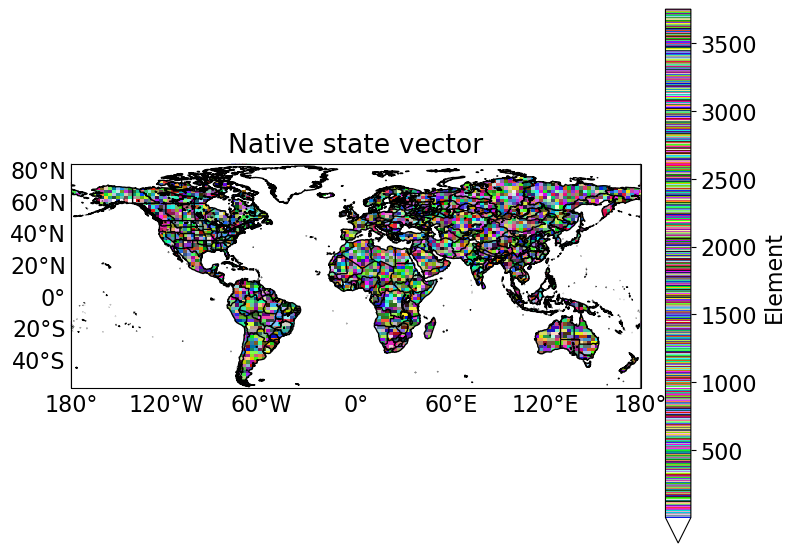

In [4]:
# Native state vector
from matplotlib.colors import ListedColormap
num_colors = 3753
random_cmap = ListedColormap(np.random.rand(num_colors,3))

cmap = random_cmap
cmap.set_under('white')

fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(ax, state_vector_labels, cmap=cmap, vmin=0.001,
           title='Native state vector', cbar_label='Element')

## January 2019

In [9]:
# Prior emissions
prior = xr.load_dataset(prior_pth)["EmisCH4_Total"].isel(time=0)
prior_old = xr.load_dataset(prior_pth_old)["EmisCH4_Total"].isel(time=0)

# Optimized scale factors
scale = xr.load_dataset(results_pth)["ScaleFactor"]

# Posterior emissions
posterior = prior * scale

In [10]:
# Total emissions in the region of interest

areas = xr.load_dataset(prior_pth)["AREA"]

total_prior_emissions = sum_total_emissions(prior, areas, mask)
total_prior_emissions_old = sum_total_emissions(prior_old, areas, mask)
total_posterior_emissions = sum_total_emissions(posterior, areas, mask)

print("Prior     emissions :", (total_prior_emissions/365)*31, "Tg/m")
print("Prior  emissions old:", (total_prior_emissions_old/365)*31, "Tg/m")
print("Posterior emissions :", (total_posterior_emissions/365)*31, "Tg/m")

Prior     emissions : 39.52954633686199 Tg/m
Prior  emissions old: 39.260889308260346 Tg/m
Posterior emissions : 31.906494575281133 Tg/m


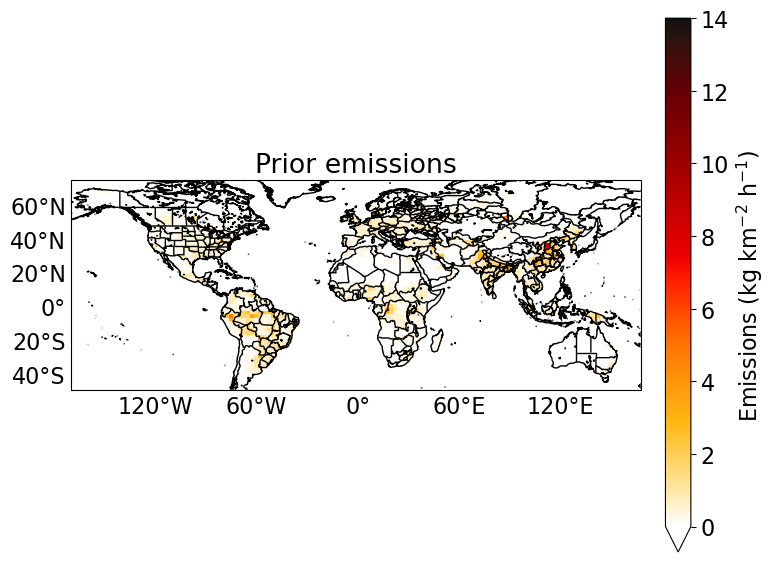

In [7]:
# Plot prior emissions
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

prior_kgkm2h = prior * (1000**2) * 60 * 60  # Units kg/km2/h

plot_field(
    ax,
    prior_kgkm2h,
    cmap=cc.cm.linear_kryw_5_100_c67_r,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    vmin=0,
    vmax=14,
    title="Prior emissions",
    cbar_label="Emissions (kg km$^{-2}$ h$^{-1}$)",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

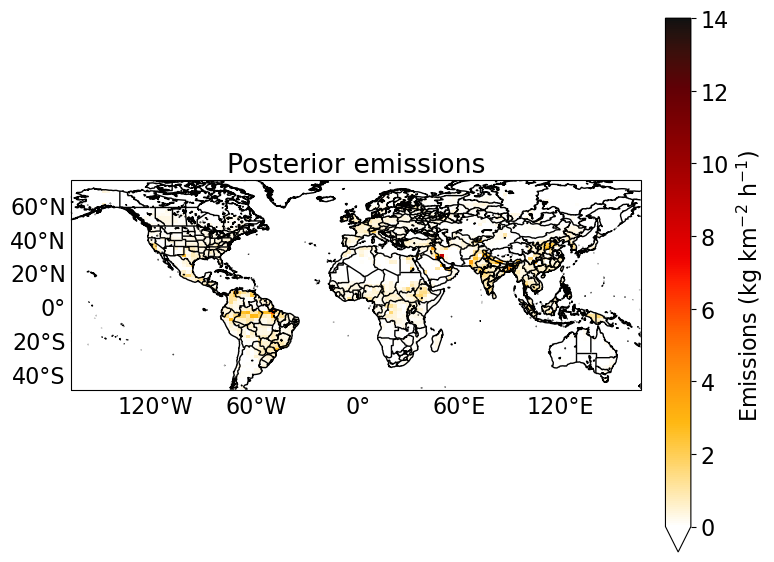

In [8]:
# Plot posterior emissions
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

posterior_kgkm2h = posterior * (1000**2) * 60 * 60  # Units kg/km2/h

plot_field(
    ax,
    posterior_kgkm2h,
    cmap=cc.cm.linear_kryw_5_100_c67_r,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    vmin=0,
    vmax=14,
    title="Posterior emissions",
    cbar_label="Emissions (kg km$^{-2}$ h$^{-1}$)",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

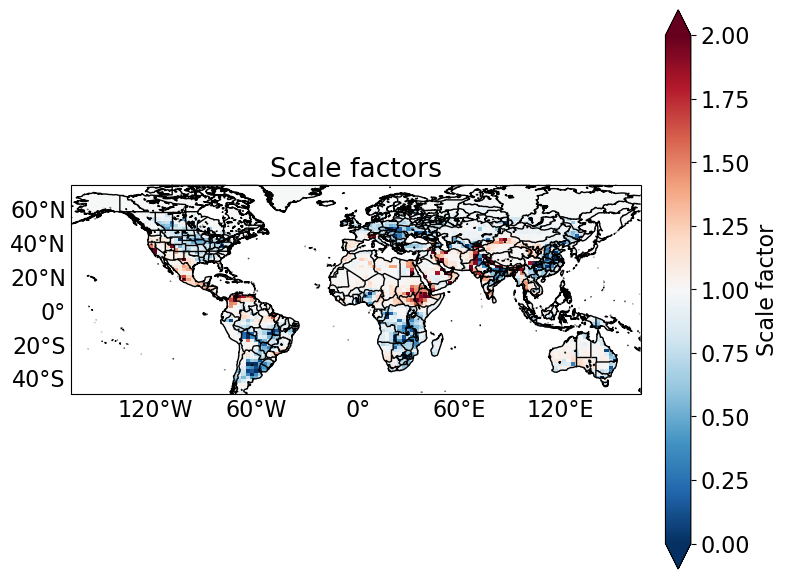

In [9]:
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    scale,
    cmap="RdBu_r",
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    vmin=0,
    vmax=2,
    title="Scale factors",
    cbar_label="Scale factor",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

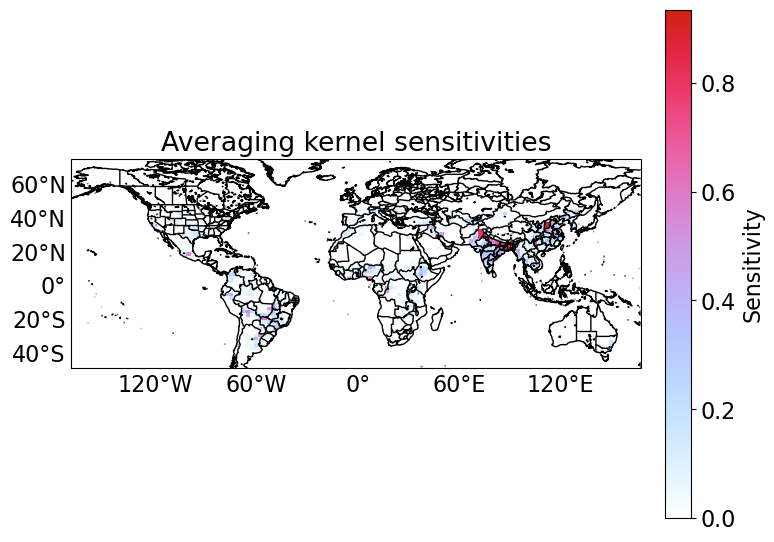

In [10]:
S_post_grid = xr.load_dataset(results_pth)["S_post"]
A_grid = xr.load_dataset(results_pth)["A"]
avkern_ROI = A_grid.where(state_vector_labels <= last_ROI_element)

fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    avkern_ROI,
    cmap=cc.cm.CET_L19,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="Averaging kernel sensitivities",
    cbar_label="Sensitivity",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

In [11]:
# ungridded inversion result is used to calculate DOFS using the trace of the averaging kernel
A_ROI = xr.load_dataset(inversion_result_path)["A"].values[:last_ROI_element, :last_ROI_element]
DOFS = np.trace(A_ROI)
print("DOFS =", DOFS)

DOFS = 108.34334


## Compare TROPOMI and GEOS-Chem columns

In [21]:
import pandas as pd
import os
import glob
import re
from utils import load_obj

def list_files(directory):
    files = glob.glob(f"{directory}/*.pkl")
    files.sort()
    dt = []
    for f in files:
        match = re.search(r'CH4____(.*?)_', f)
        date_time = match.group(1)
        date_time = f"{date_time[:4]}-{date_time[4:6]}-{date_time[6:8]}T{date_time[9:11]}:{date_time[11:13]}:{date_time[13:]}"
        dt.append(np.datetime64(date_time))
    return dt

def match_observations(prior_directory, posterior_directory):

    # Load TROPOMI/GEOS-Chem and Jacobian matrix data from the .nc file
    dat = xr.open_dataset(prior_directory)
    dat.close()

    # Extract the timesteps in a 1d array
    timesteps = dat["geoschem_methane"].coords['time'].values

    # Match to closest posterior timestep (TROPOMI retrieval time)
    posterior_timesteps = list_files(posterior_directory)
    diffs = np.abs(timesteps[:, np.newaxis] - np.array(posterior_timesteps))
    timesteps_match = timesteps[np.argmin(diffs, axis=0)]
    
    time = np.array([])
    lat = np.array([])
    lon = np.array([])
    tropomi_gc_grid = np.array([])
    tropomi_sat_grid = np.array([])
    geos_prior = np.array([])
    geos_posterior = np.array([])
    posterior_lat = np.array([])
    posterior_lon = np.array([])
    observation_count = np.array([])
    observation_count_posterior = np.array([])
    
    # Load GC/TROPOMI data, obs counts, lats, lons. TROPOMI data is mapped onto GC grid already
    for t in range(len(timesteps_match)):

        GC_all = dat["geoschem_methane"].values[t,:,:]
        non_nans = np.where(~np.isnan(GC_all))
        GC = GC_all[non_nans]
        
        tropomi_all = dat["tropomi_methane"].values[t,:,:]
        tropomi_methane_gc_grid = tropomi_all[non_nans]

        tropomi_lat = dat["lat_sat"].values[t,:,:]
        tropomi_lat = tropomi_lat[non_nans]
        tropomi_lon = dat["lon_sat"].values[t,:,:]
        tropomi_lon = tropomi_lon[non_nans]
        
        obs_count_all = dat["observation_count"].values[t,:,:]
        obs_count = obs_count_all[non_nans]

        t_array = np.full_like(tropomi_methane_gc_grid, t)

        # Record lat, lon, tropomi ch4, and geos ch4
        time = np.concatenate((time, t_array))
        lat = np.concatenate((lat, tropomi_lat))
        lon = np.concatenate((lon, tropomi_lon))
        tropomi_gc_grid = np.concatenate((tropomi_gc_grid, tropomi_methane_gc_grid))
        geos_prior = np.concatenate((geos_prior, GC))
        observation_count = np.concatenate((observation_count, obs_count))
    
    # Load posterior GC methane
    post_files = np.sort(os.listdir(posterior_directory))
    for f in post_files:
        pth_posterior = os.path.join(posterior_directory, f)
        obj_posterior = load_obj(pth_posterior)
        obs_GC_posterior = obj_posterior["obs_GC"][:,1]
        tropomi_methane_sat_grid = obj_posterior["obs_GC"][:,0]
        lat_sat = obj_posterior["obs_GC"][:,3]
        lon_sat = obj_posterior["obs_GC"][:,2]
        obs_count_post = obj_posterior["obs_GC"][:,4]
        tropomi_sat_grid = np.concatenate((tropomi_sat_grid, tropomi_methane_sat_grid))
        geos_posterior = np.concatenate((geos_posterior, obs_GC_posterior))
        posterior_lat = np.concatenate((posterior_lat, lat_sat))
        posterior_lon = np.concatenate((posterior_lon, lon_sat))
        observation_count_posterior = np.concatenate((observation_count_posterior, obs_count_post))

    df = pd.DataFrame()
    df["time"] = time
    df["lat"] = lat
    df["lon"] = lon
    df["tropomi"] = tropomi_gc_grid
    df["geos_prior"] = geos_prior
    df["diff_tropomi_prior"] = geos_prior - tropomi_gc_grid
    df["observation_count"] = observation_count

    df_post = pd.DataFrame()
    df_post["geos_posterior"] = geos_posterior
    df_post["diff_tropomi_posterior"] = geos_posterior - tropomi_sat_grid
    df_post["lat"] = posterior_lat
    df_post["lon"] = posterior_lon
    df_post["observation_count"] = observation_count_posterior

    return df, df_post

In [32]:
# January

data_dir_post = "/n/holyscratch01/jacob_lab/mhe/Global_IMI_2019/inversion_jan/data_visualization_posterior"
data_dir_prior = "/n/holyscratch01/jacob_lab/mhe/calc_sensi_test/sensi_20190101_20190101.nc"

df_jan, df_post_jan = match_observations(data_dir_prior, data_dir_post)

In [27]:
df_jan

,time,lat,lon,tropomi,geos_prior,diff_tropomi_prior,observation_count
0,0.0,-46.0,170.0,1768.749390,1768.011841,-0.737549,11.000000
1,0.0,-42.0,172.5,1751.480103,1763.169067,11.688965,2.441432
2,0.0,-42.0,175.0,1766.650513,1768.197754,1.547241,1.558568
3,0.0,-40.0,175.0,1758.197632,1772.689087,14.491455,7.997797
4,0.0,-38.0,175.0,1762.966431,1775.817261,12.850830,13.002203
...,...,...,...,...,...,...,...
34298,435.0,52.0,-65.0,1870.522949,1845.921021,-24.601929,18.230200
34299,435.0,52.0,-62.5,1868.902100,1846.026733,-22.875366,34.828953
34300,435.0,52.0,-60.0,1861.798218,1845.601196,-16.197021,57.983299
34301,435.0,52.0,-57.5,1859.142090,1844.791870,-14.350220,33.142231


In [33]:
df_post_jan

,geos_posterior,diff_tropomi_posterior,lat,lon,observation_count
0,1761.163086,3.793945,-46.260971,169.613861,0.0
1,1761.308960,-0.091187,-46.232906,169.747009,0.0
2,1761.265137,-2.553345,-46.198227,169.597198,0.0
3,1760.887817,-11.156494,-46.170162,169.730194,0.0
4,1761.237915,-6.617798,-46.142502,169.861282,0.0
...,...,...,...,...,...
6362912,1837.078491,14.188599,40.474625,-122.180382,0.0
6362913,1832.233643,2.367554,40.602592,-124.246475,0.0
6362914,1836.900391,7.238159,40.537151,-122.189133,0.0
6362915,1836.764771,8.452759,40.599613,-122.198074,0.0


In [34]:
# Simple averaging scheme to grid the XCH4 data at 0.1 x 0.1 resolution
df_jan["lat"] = np.round(df_jan["lat"], 1)
df_jan["lon"] = np.round(df_jan["lon"], 1)
visualization_df = df_jan.groupby(["lat", "lon"]).mean()
ds_jan = visualization_df.to_xarray()

df_post_jan["lat"] = np.round(df_post_jan["lat"], 1)
df_post_jan["lon"] = np.round(df_post_jan["lon"], 1)
visualization_df = df_post_jan.groupby(["lat", "lon"]).mean()
ds_post_jan = visualization_df.to_xarray()

In [35]:
print(
    "Bias in prior     :",
    np.round(
        np.average(
            df_jan["diff_tropomi_prior"], weights=df_jan["observation_count"]
        ),
        2,
    ),
    "ppb",
)

print(
    "Bias in posterior :",
    np.round(
        np.average(
            df_post_jan["diff_tropomi_posterior"],
            #weights=df_post_jan["observation_count"],
        ),
        2,
    ),
    "ppb",
)

Bias in prior     : 1.41 ppb
Bias in posterior : -2.3 ppb


/n/jacob_lab/Lab/seasfs01/Users/mhe/python/mamba/envs/imi_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


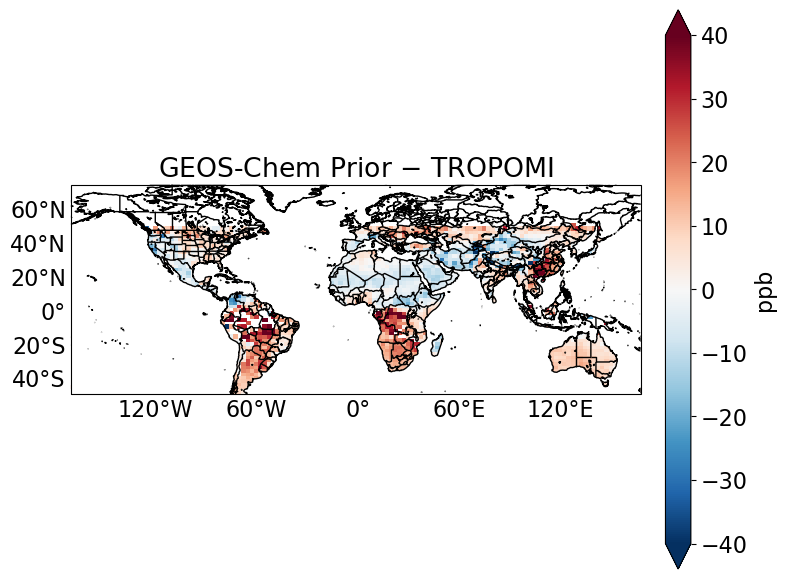

In [19]:
# Plot differences between GEOS-Chem and TROPOMI XCH4 on 2 x 2.5 grid
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    ds_jan["diff_tropomi_prior"],
    cmap="RdBu_r",
    vmin=-40,
    vmax=40,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem Prior $-$ TROPOMI",
    cbar_label="ppb",
    mask=mask,
    only_ROI=False,
)

/n/home12/mhe/.conda/envs/imi_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


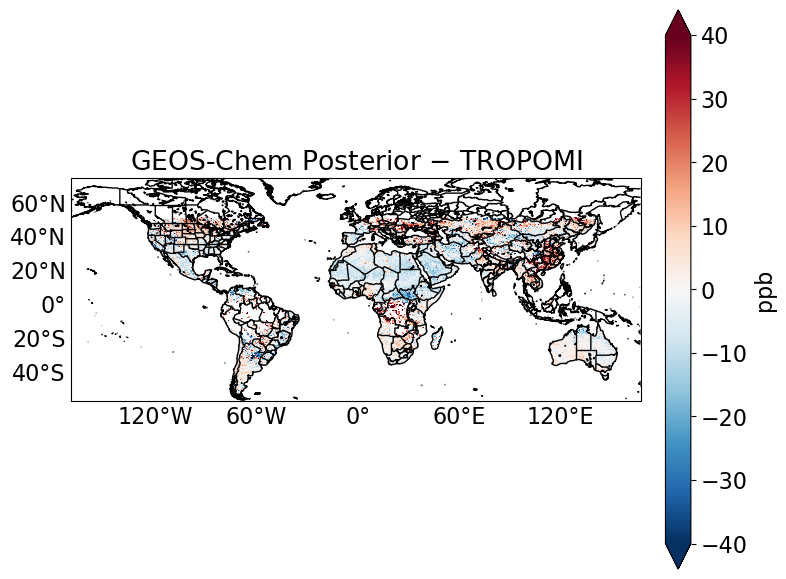

In [36]:
# Plot differences between GEOS-Chem and TROPOMI XCH4 on 2 x 2.5 grid
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    ds_post_jan["diff_tropomi_posterior"],
    cmap="RdBu_r",
    vmin=-40,
    vmax=40,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem Posterior $-$ TROPOMI",
    cbar_label="ppb",
    mask=mask,
    only_ROI=False,
)

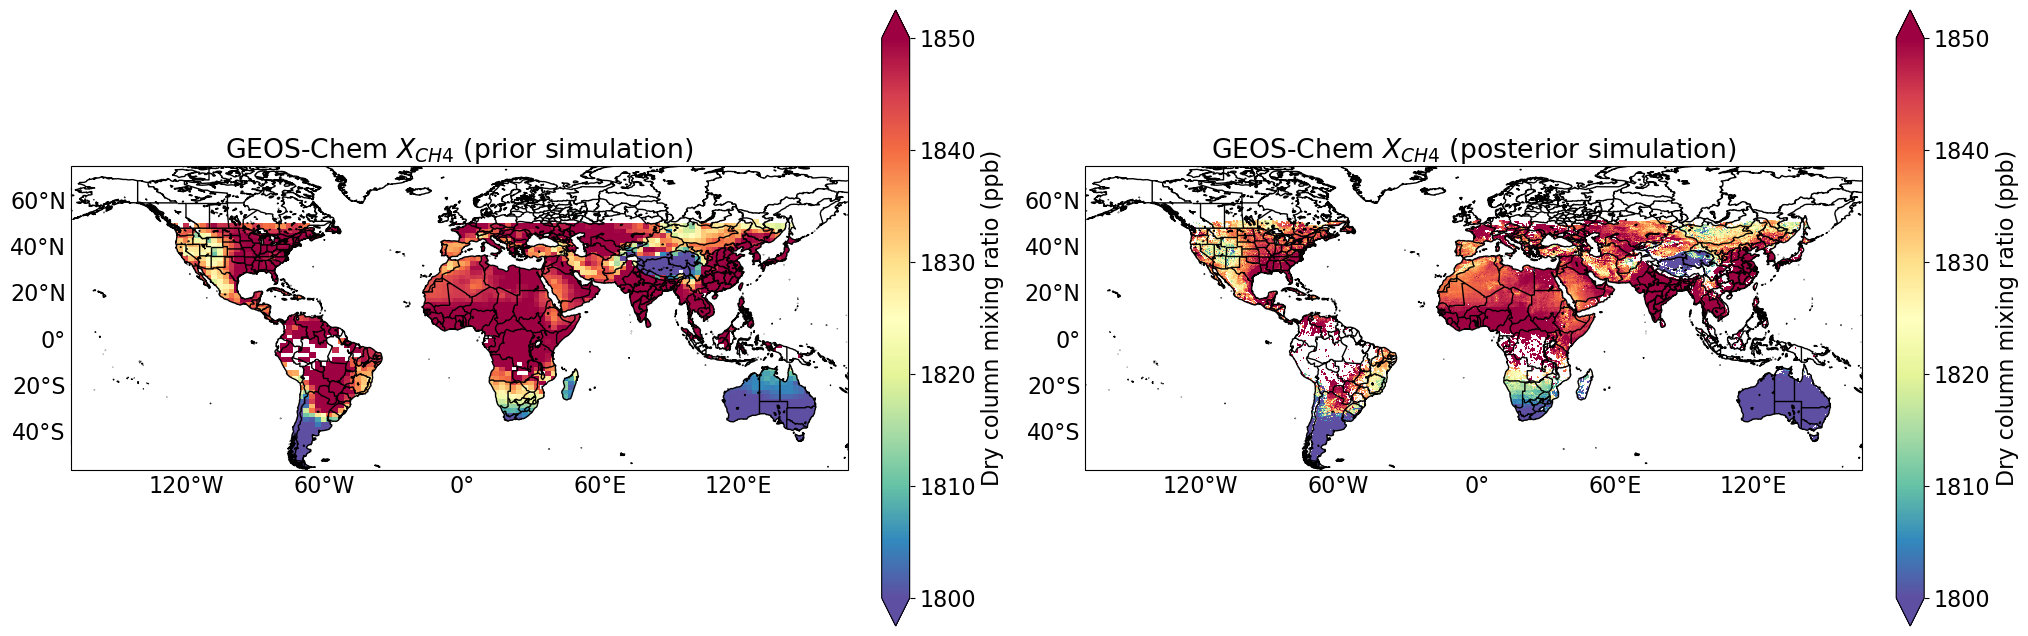

In [38]:
# Mean prior and posterior GEOS-Chem XCH4 columns on 2 x2.5 grid
fig = plt.figure(figsize=(24, 8))
ax1, ax2 = fig.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax1,
    ds_jan["geos_prior"],
    cmap="Spectral_r",
    vmin=1800,
    vmax=1850,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem $X_{CH4}$ (prior simulation)",
    cbar_label="Dry column mixing ratio (ppb)",
    mask=mask,
    only_ROI=False,
)

plot_field(
    ax2,
    ds_post_jan["geos_posterior"],
    cmap="Spectral_r",
    vmin=1800,
    vmax=1850,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem $X_{CH4}$ (posterior simulation)",
    cbar_label="Dry column mixing ratio (ppb)",
    mask=mask,
    only_ROI=False,
)

### Check January 2019 initial condition - TROPOMI

In [20]:
# for timestep = 0

import pandas as pd
import os
import glob
import re
from utils import load_obj

def list_files(directory):
    files = glob.glob(f"{directory}/*.pkl")
    files.sort()
    dt = []
    for f in files:
        match = re.search(r'CH4____(.*?)_', f)
        date_time = match.group(1)
        date_time = f"{date_time[:4]}-{date_time[4:6]}-{date_time[6:8]}T{date_time[9:11]}:{date_time[11:13]}:{date_time[13:]}"
        dt.append(np.datetime64(date_time))
    return dt

def match_observations(prior_directory, posterior_directory):

    # Load TROPOMI/GEOS-Chem and Jacobian matrix data from the .nc file
    dat = xr.open_dataset(prior_directory)
    dat.close()

    # Extract the timesteps in a 1d array
    timesteps = dat["geoschem_methane"].coords['time'].values

    # Match to closest posterior timestep (TROPOMI retrieval time)
    posterior_timesteps = list_files(data_dir_post)
    diffs = np.abs(timesteps[:, np.newaxis] - np.array(posterior_timesteps))
    timesteps_match = timesteps[np.argmin(diffs, axis=0)]
    
    lat = np.array([])
    lon = np.array([])
    tropomi = np.array([])
    geos_prior = np.array([])
    geos_posterior = np.array([])
    observation_count = np.array([])
    
    # Load GC/TROPOMI data, obs counts, lats, lons. TROPOMI data is mapped onto GC grid already
    # for t in range(1):

    GC_all = dat["geoschem_methane"].values[0,:,:]
    non_nans = np.where(~np.isnan(GC_all))
    GC = GC_all[non_nans]
    
    tropomi_all = dat["tropomi_methane"].values[0,:,:]
    tropomi_methane = tropomi_all[non_nans]

    tropomi_lat = dat["lat_sat"].values[0,:,:]
    tropomi_lat = tropomi_lat[non_nans]
    tropomi_lon = dat["lon_sat"].values[0,:,:]
    tropomi_lon = tropomi_lon[non_nans]
    
    obs_count_all = dat["observation_count"].values[0,:,:]
    obs_count = obs_count_all[non_nans]

    # Record lat, lon, tropomi ch4, and geos ch4
    lat = np.concatenate((lat, tropomi_lat))
    lon = np.concatenate((lon, tropomi_lon))
    tropomi = np.concatenate((tropomi, tropomi_methane))
    geos_prior = np.concatenate((geos_prior, GC))
    observation_count = np.concatenate((observation_count, obs_count))
    
    # Load posterior GC methane
    post_files = np.sort(os.listdir(posterior_directory))
    for f in post_files:
        pth_posterior = os.path.join(posterior_directory, f)
        obj_posterior = load_obj(pth_posterior)
        obs_GC_posterior = obj_posterior["obs_GC"]

    df = pd.DataFrame()
    df["lat"] = lat
    df["lon"] = lon
    df["tropomi"] = tropomi
    df["geos_prior"] = geos_prior
    # df["geos_posterior"] = geos_posterior
    df["diff_tropomi_prior"] = geos_prior - tropomi
    # df["diff_tropomi_posterior"] = geos_posterior - tropomi
    df["observation_count"] = observation_count

    return df

data_dir_post = "/n/holyscratch01/jacob_lab/mhe/Global_IMI_2019/inversion/data_visualization_posterior"
data_dir_prior = "/n/holyscratch01/jacob_lab/mhe/calc_sensi_test/sensi_20190101_20190101.nc"

df_initial = match_observations(data_dir_prior, data_dir_post)

In [21]:
# Simple averaging scheme to grid the XCH4 data at 0.1 x 0.1 resolution
df_initial["lat"] = np.round(df_initial["lat"], 1)
df_initial["lon"] = np.round(df_initial["lon"], 1)
visualization_df_initial = df_initial.groupby(["lat", "lon"]).mean()
ds_initial = visualization_df_initial.to_xarray()

In [30]:
ds_initial["diff_tropomi_prior"]

<xarray.DataArray 'diff_tropomi_prior' (lat: 6, lon: 5)>
array([[        nan, -0.73754883,         nan,         nan,         nan],
       [        nan,         nan, 11.68896484,  1.54724121,         nan],
       [        nan,         nan,         nan, 14.49145508,         nan],
       [        nan,         nan,         nan, 12.85083008, 11.99353027],
       [-8.63000488,         nan,         nan,         nan,         nan],
       [-1.39892578,         nan,         nan,         nan,         nan]])
Coordinates:
  * lat      (lat) float64 -46.0 -42.0 -40.0 -38.0 42.0 44.0
  * lon      (lon) float64 145.0 170.0 172.5 175.0 177.5

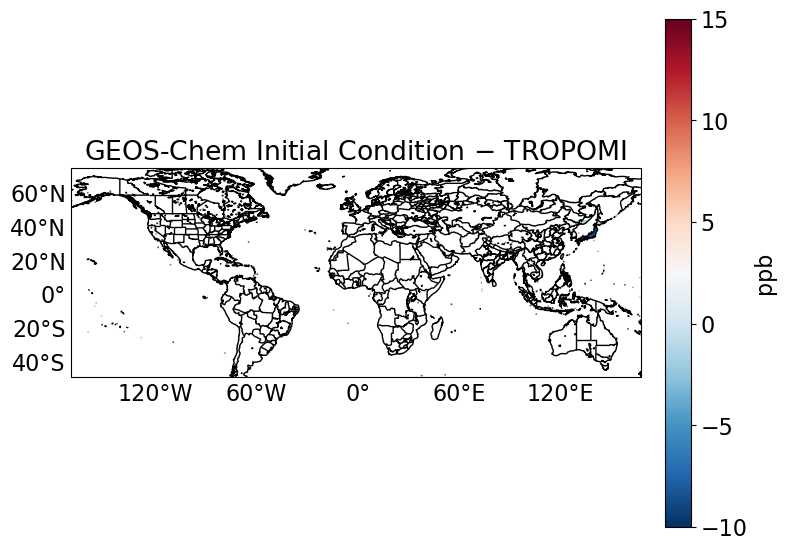

In [32]:
# Mean TROPOMI XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    ds_initial["diff_tropomi_prior"],
    cmap="RdBu_r",
    vmin=-10,
    vmax=15,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem Initial Condition $-$ TROPOMI",
    cbar_label="ppb",
    mask=mask,
    only_ROI=False,
)

## July 2019

In [39]:
prior_pth = "~/mhe/Global_IMI_2019/jacobian_runs/Global_IMI_2019_0000/OutputDir/HEMCO_diagnostics.201907010000.nc"
results_pth = "~/mhe/gridded_posterior_20190701.nc"
inversion_result_path = "~/mhe/jacobian_test/inversion_result_20190701.nc"

# Set latitude/longitude bounds for plots

degx = 4 * 2.5
degy = 4 * 2

lon_bounds = [np.min(state_vector.lon.values) + degx, np.max(state_vector.lon.values) - degx]
lat_bounds = [np.min(state_vector.lat.values), np.max(state_vector.lat.values) - degy]

In [40]:
# Prior emissions
prior = xr.load_dataset(prior_pth)["EmisCH4_Total"].isel(time=0)

# Optimized scale factors
scale = xr.load_dataset(results_pth)["ScaleFactor"]

# Posterior emissions
posterior = prior * scale

# Total emissions in the region of interest

areas = xr.load_dataset(prior_pth)["AREA"]

total_prior_emissions = sum_total_emissions(prior, areas, mask)
total_posterior_emissions = sum_total_emissions(posterior, areas, mask)

print("Prior     emissions :", (total_prior_emissions/365)*31, "Tg/m")
print("Posterior emissions :", (total_posterior_emissions/365)*31, "Tg/m")

Prior     emissions : 48.40430820368942 Tg/m
Posterior emissions : 32.81530811137996 Tg/m


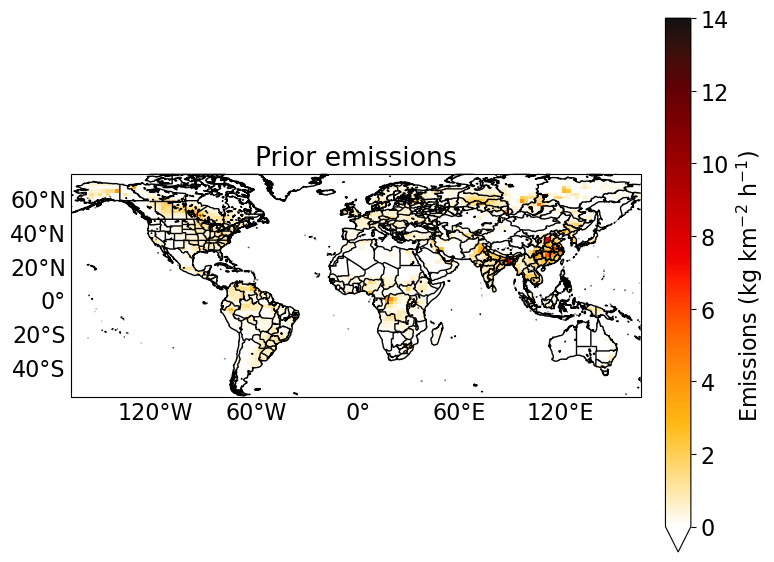

In [41]:
# Plot prior emissions
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

prior_kgkm2h = prior * (1000**2) * 60 * 60  # Units kg/km2/h

plot_field(
    ax,
    prior_kgkm2h,
    cmap=cc.cm.linear_kryw_5_100_c67_r,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    vmin=0,
    vmax=14,
    title="Prior emissions",
    cbar_label="Emissions (kg km$^{-2}$ h$^{-1}$)",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

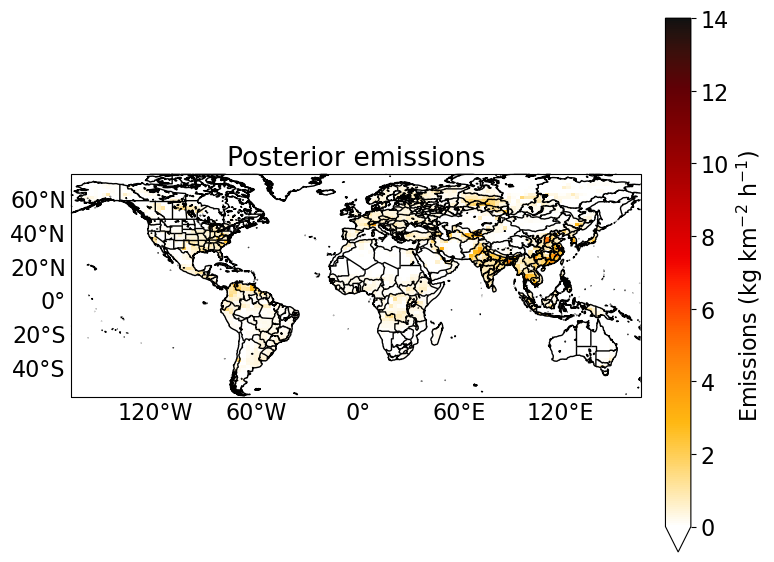

In [42]:
# Plot posterior emissions
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

posterior_kgkm2h = posterior * (1000**2) * 60 * 60  # Units kg/km2/h

plot_field(
    ax,
    posterior_kgkm2h,
    cmap=cc.cm.linear_kryw_5_100_c67_r,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    vmin=0,
    vmax=14,
    title="Posterior emissions",
    cbar_label="Emissions (kg km$^{-2}$ h$^{-1}$)",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

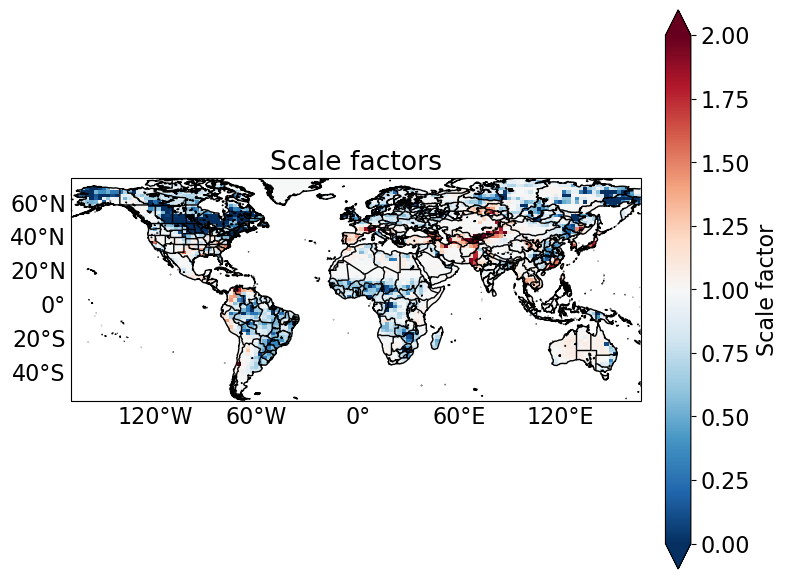

In [43]:
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    scale,
    cmap="RdBu_r",
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    vmin=0,
    vmax=2,
    title="Scale factors",
    cbar_label="Scale factor",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

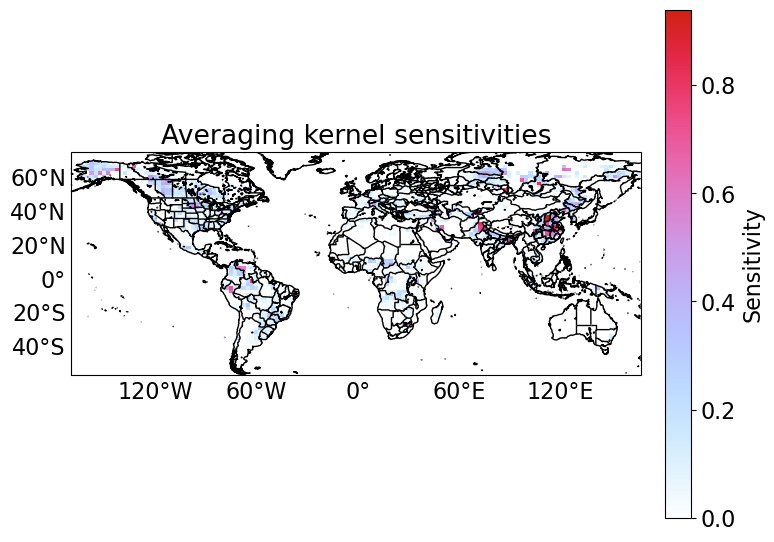

In [44]:
S_post_grid = xr.load_dataset(results_pth)["S_post"]
A_grid = xr.load_dataset(results_pth)["A"]
avkern_ROI = A_grid.where(state_vector_labels <= last_ROI_element)

fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    avkern_ROI,
    cmap=cc.cm.CET_L19,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="Averaging kernel sensitivities",
    cbar_label="Sensitivity",
    only_ROI=True,
    state_vector_labels=state_vector_labels,
    last_ROI_element=last_ROI_element,
)

In [45]:
# ungridded inversion result is used to calculate DOFS using the trace of the averaging kernel
A_ROI = xr.load_dataset(inversion_result_path)["A"].values[:last_ROI_element, :last_ROI_element]
DOFS = np.trace(A_ROI)
print("DOFS =", DOFS)

DOFS = 183.63934


## Compare TROPOMI and GEOS-Chem columns

In [46]:
data_dir_post = "/n/holyscratch01/jacob_lab/mhe/Global_IMI_2019/inversion/data_visualization_posterior"
data_dir_prior = "/n/holyscratch01/jacob_lab/mhe/calc_sensi_test/sensi_20190701_20190701.nc"

df_jul, df_post_jul = match_observations(data_dir_prior, data_dir_post)

In [47]:
# Simple averaging scheme to grid the XCH4 data at 0.1 x 0.1 resolution
df_jul["lat"] = np.round(df_jul["lat"], 1)
df_jul["lon"] = np.round(df_jul["lon"], 1)
visualization_df = df_jul.groupby(["lat", "lon"]).mean()
ds_jul = visualization_df.to_xarray()

df_post_jul["lat"] = np.round(df_post_jul["lat"], 1)
df_post_jul["lon"] = np.round(df_post_jul["lon"], 1)
visualization_df = df_post_jul.groupby(["lat", "lon"]).mean()
ds_post_jul = visualization_df.to_xarray()

/n/home12/mhe/.conda/envs/imi_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


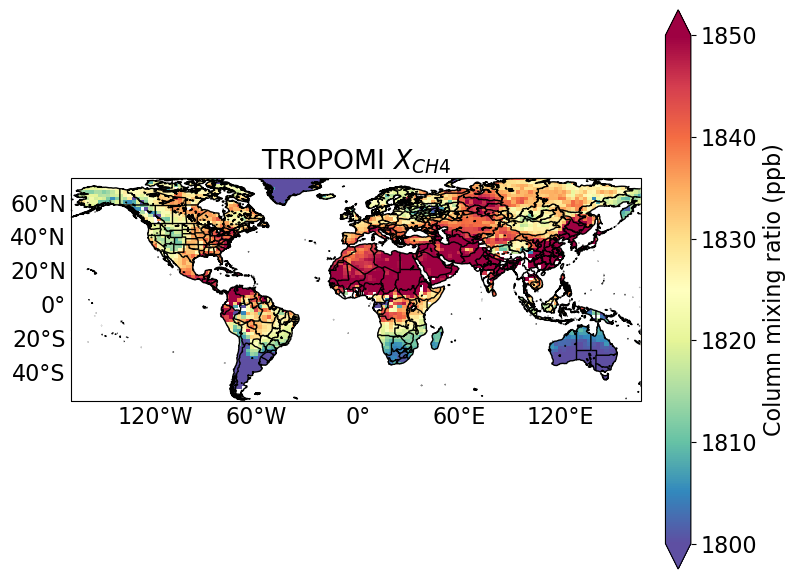

In [48]:
# Mean TROPOMI XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    ds_jul["tropomi"],
    cmap="Spectral_r",
    vmin=1800,
    vmax=1850,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="TROPOMI $X_{CH4}$",
    cbar_label="Column mixing ratio (ppb)",
    mask=mask,
    only_ROI=False,
)

In [49]:
print(
    "Bias in prior     :",
    np.round(
        np.average(
            df_jul["diff_tropomi_prior"], weights=df_jul["observation_count"]
        ),
        2,
    ),
    "ppb",
)

print(
    "Bias in posterior :",
    np.round(
        np.average(
            df_post_jul["diff_tropomi_posterior"],
            #weights=df_post_jan["observation_count"],
        ),
        2,
    ),
    "ppb",
)

Bias in prior     : 7.82 ppb
Bias in posterior : -0.75 ppb


/n/home12/mhe/.conda/envs/imi_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


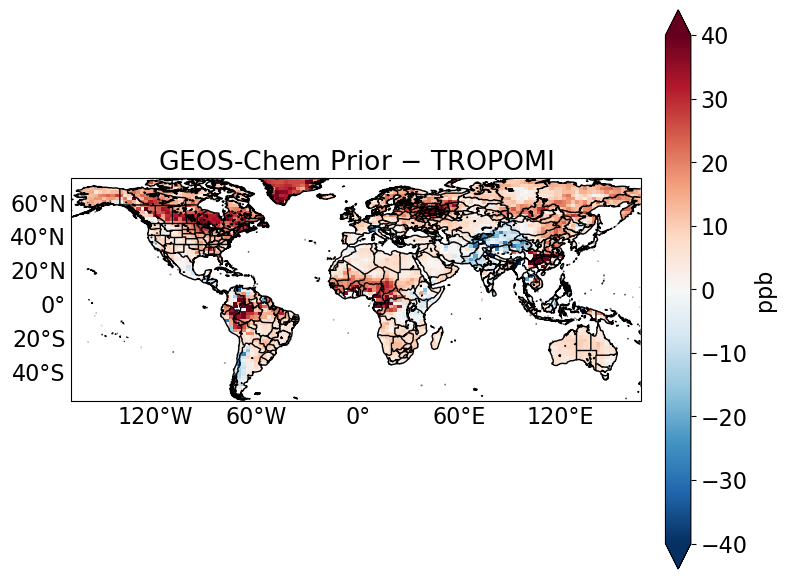

In [50]:
# Plot differences between GEOS-Chem and TROPOMI XCH4 on 2 x 2.5 grid
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    ds_jul["diff_tropomi_prior"],
    cmap="RdBu_r",
    vmin=-40,
    vmax=40,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem Prior $-$ TROPOMI",
    cbar_label="ppb",
    mask=mask,
    only_ROI=False,
)

/n/home12/mhe/.conda/envs/imi_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


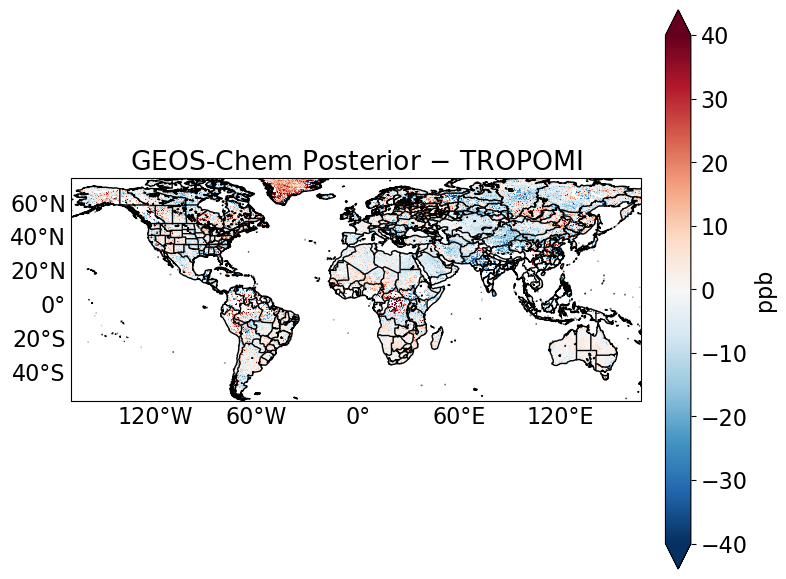

In [51]:
# Plot differences between GEOS-Chem and TROPOMI XCH4 on 2 x 2.5 grid
fig = plt.figure(figsize=(8, 8))
plt.rcParams.update({"font.size": 16})
ax = fig.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax,
    ds_post_jul["diff_tropomi_posterior"],
    cmap="RdBu_r",
    vmin=-40,
    vmax=40,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem Posterior $-$ TROPOMI",
    cbar_label="ppb",
    mask=mask,
    only_ROI=False,
)

/n/home12/mhe/.conda/envs/imi_env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1479: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


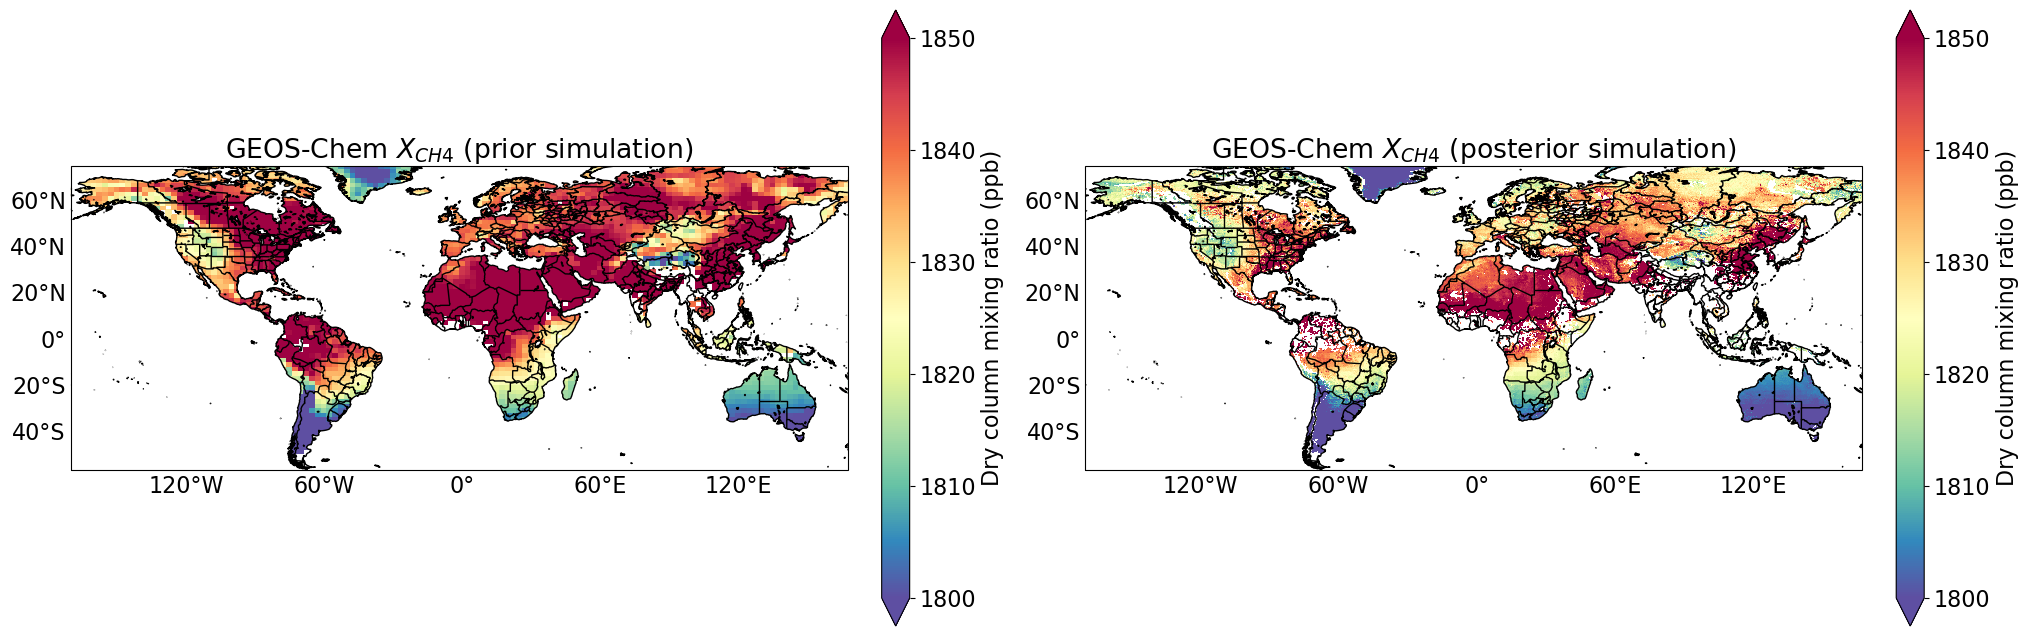

In [52]:
# Mean prior and posterior GEOS-Chem XCH4 columns on 2 x2.5 grid
fig = plt.figure(figsize=(24, 8))
ax1, ax2 = fig.subplots(1, 2, subplot_kw={"projection": ccrs.PlateCarree()})

plot_field(
    ax1,
    ds_jul["geos_prior"],
    cmap="Spectral_r",
    vmin=1800,
    vmax=1850,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem $X_{CH4}$ (prior simulation)",
    cbar_label="Dry column mixing ratio (ppb)",
    mask=mask,
    only_ROI=False,
)

plot_field(
    ax2,
    ds_post_jul["geos_posterior"],
    cmap="Spectral_r",
    vmin=1800,
    vmax=1850,
    lon_bounds=lon_bounds,
    lat_bounds=lat_bounds,
    title="GEOS-Chem $X_{CH4}$ (posterior simulation)",
    cbar_label="Dry column mixing ratio (ppb)",
    mask=mask,
    only_ROI=False,
)